# 1. Undestand the Industry

1. **Fluxo do dinheiro e da informação**

Informação: quando o cliente paga, os dados vão da maquininha ou checkout > adquirente > bandeira > banco emissor > resposta (aprovado ou negado).

Dinheiro: só depois vem o repasse. O emissor paga o adquirente, que desconta taxas e repassa ao lojista.

Principais players: cliente, lojista, adquirente, subadquirente, gateway, bandeira e emissor.

2. **Diferença entre adquirente, subadquirente e gateway**

Adquirente: o “banco da maquininha”, que liquida e paga o lojista.

Subadquirente: intermediário que recebe do adquirente e repassa para pequenos lojistas.

Gateway: só leva os dados da compra para o adquirente; não mexe com dinheiro.

No fluxo:

Adquirente paga direto ao lojista.

Subadquirente paga ao lojista, mas recebe antes do adquirente.

Gateway só transmite a informação.

3. **Chargeback x Cancelamento**

Chargeback: cliente contesta a compra no banco (fraude, produto não recebido etc.). O dinheiro volta pro cliente e o lojista arca com o prejuízo.

Cancelamento: lojista estorna a compra no próprio sistema, de forma combinada com o cliente.

Fraude: grande parte dos chargebacks vem de fraude (cartão clonado ou compra não reconhecida).

# 2. Solve The Problem

* Escutar e validar a frustração do cliente, reconhecendo que a situação é
injusta.

* Revisar novamente toda a documentação e verificar se existe alguma evidência adicional que não foi enviada. Se houver, ajudar o cliente a preparar um recurso ou nova contestação junto ao emissor.

* Transparência: explicar claramente o processo, mostrando que a decisão veio do banco emissor, mas sem passar a impressão de que a empresa simplesmente 'lavou as mãos'.

* Ir além da obrigação: se o cliente realmente tiver provas sólidas de entrega e não houver mais recurso possível, considerar uma compensação comercial (um crédito, reembolso parcial ou outra forma de minimizar a perda). Isso reforça o posicionamento de que o cliente está em primeiro lugar.

* Apoio contínuo: oferecer-se para ajudar em próximas transações, orientando como fortalecer a comprovação de entrega para evitar novos chargebacks do mesmo tipo.

# 3. Get your hands dirty

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('/content/transactional-sample.csv')
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['device_id'] = df['device_id'].astype('Int64').astype('string')

## investigação

### Top users com maior número de chargebacks.

 * Nesse primeiro momento, busco localizar usuários com longo histórico de chargebacks e investiga-los mais a frente.
 * Foi possível observar que os usuários com maior volume de chargebacks são respectivamente:
    1. *11750 - 25 chargebacks*
    2. *91637 - 19 chargebacks*
    3. *79054 - 15 chargebacks*
    4. *96025 - 13 chargebacks*
    5. *78262 - 12 chargebacks*




In [91]:
cbk_users = df[df['has_cbk'] == True].groupby('user_id').size().sort_values(ascending=False)
cbk_users = cbk_users[cbk_users > 1]
print(cbk_users.head(10))

user_id
11750    25
91637    19
79054    15
96025    13
78262    12
75710    10
7725      7
17929     6
21768     6
28218     5
dtype: int64


### Users com maior número de cartões



*   Dando sequência a investigação, busco por usuários com maior numero de cartões utilizados em transações, com o objetivo de observar se há uma correlação com a lista de usuários com maior histórico de chargebacks.
*   Após análise observamos que o top 5 da lista de usuários com maior número de cartões contém os mesmos usuários do top 5 da lista de users com maior histórico de chargebacks em ordem, podendo sinalizar uma possível tentativa de evasão dos mecanismos de detecção de fraudes, utilizando múltiplos cartões para solicitar chargebacks.


In [49]:
cards_per_user = df.groupby('user_id')['card_number'].nunique().sort_values(ascending=False)
print(cards_per_user.head(10))

user_id
11750    31
91637    22
79054    15
96025    10
78262    10
7695      7
67519     6
17929     6
34548     6
99396     5
Name: card_number, dtype: int64


###Análise do top 5





*   O Objetivo nessa etapa é identificar padrões dentro da lista de usuários com mais chargebacks e mais cartões utilizados.
*   Pude notar alguns comportamentos semelhantes entre eles:
    
    1.   Todos possuem suas transações concentradas em poucos comerciantes.
    2.   A média de valores das transações é alta (acima de 500 reais).
    
*   O user 11750 realizou transações com mais de um dispositivo e com o mesmo comerciante, é um comportamento que merece atenção.



In [146]:

df['transaction_date'] = pd.to_datetime(df['transaction_date'])

top5_users = [11750, 91637, 79054, 96025, 78262]

df_top5 = df[df['user_id'].isin(top5_users)].copy()
df_top5['transaction_hour'] = df_top5['transaction_date'].dt.hour
df_cbk = df_top5[df_top5['has_cbk']].copy()
cbk_por_user_merchant_device = df_cbk.groupby(['user_id', 'merchant_id', 'device_id']).agg(
    num_chargebacks=('has_cbk', 'sum'),
    media_valor=('transaction_amount', 'mean'),
    media_hora=('transaction_hour', 'mean')
).reset_index()
display(cbk_por_user_merchant_device)

devices_compartilhados = (
    df_cbk.groupby('device_id')['user_id']
    .nunique()
    .reset_index(name='num_usuarios')
    .query('num_usuarios > 1')
    .sort_values(by='num_usuarios', ascending=False)
)



,user_id,merchant_id,device_id,num_chargebacks,media_valor,media_hora
0,11750,17275,342890,8,624.192500,16.000000
1,11750,17275,542535,6,542.691667,18.000000
2,11750,17275,670695,4,563.760000,16.000000
3,11750,66876,342890,7,627.885714,16.714286
4,78262,49919,547440,2,4093.545000,18.000000
5,78262,59875,547440,3,1031.066667,10.000000
6,78262,65330,547440,7,3416.864286,19.857143
7,79054,1308,101848,5,2104.064000,7.600000
8,79054,18267,101848,3,1997.716667,20.333333
9,79054,36617,101848,4,2010.760000,11.500000


### Comerciantes com 100% de taxa de chargebacks em suas transações.



*   Nessa etapa, filtrei apenas comerciantes com mais de 5 transações para evitar possíveis falsos positivos.
*   Pude observar casos de comerciantes com mais de 10 transações, na qual todas resultaram em chargeback, o que pode indicar que o comerciante esta burlando o sistema ou agindo de forma coordenada, já q alguns desses comerciantes também foram citados nos levantamentos anteriores referentes a users suspeitos, como é o caso do comerciante de ID 1308.



In [162]:
total_por_merchant = df.groupby('merchant_id').size().rename('total_transacoes')

cbk_por_merchant = df[df['has_cbk']].groupby('merchant_id').size().rename('chargebacks')

taxa_cbk_merchant = pd.concat([total_por_merchant, cbk_por_merchant], axis=1).fillna(0)

taxa_cbk_merchant['taxa_chargeback'] = taxa_cbk_merchant['chargebacks'] / taxa_cbk_merchant['total_transacoes']

comerciantes_suspeitos = taxa_cbk_merchant[
    (taxa_cbk_merchant['taxa_chargeback'] == 1.0) &
    (taxa_cbk_merchant['total_transacoes'] > 5)
].sort_values(by='total_transacoes', ascending=False)

print(comerciantes_suspeitos)


             total_transacoes  chargebacks  taxa_chargeback
merchant_id                                                
1308                       15         15.0              1.0
44927                      11         11.0              1.0
73271                      10         10.0              1.0
38337                       6          6.0              1.0
48126                       6          6.0              1.0
75917                       6          6.0              1.0
81795                       6          6.0              1.0


### Análise de horários



*   Durante essa etapa, busquei uma demonstração visual da correlação entre horários mais frequentes de chargeback e horários mais frequentes de transações.
*   De acordo com o gráfico, ambas as distribuições são semelhantes e reforçam a criticidade do período da noite e madrugada.



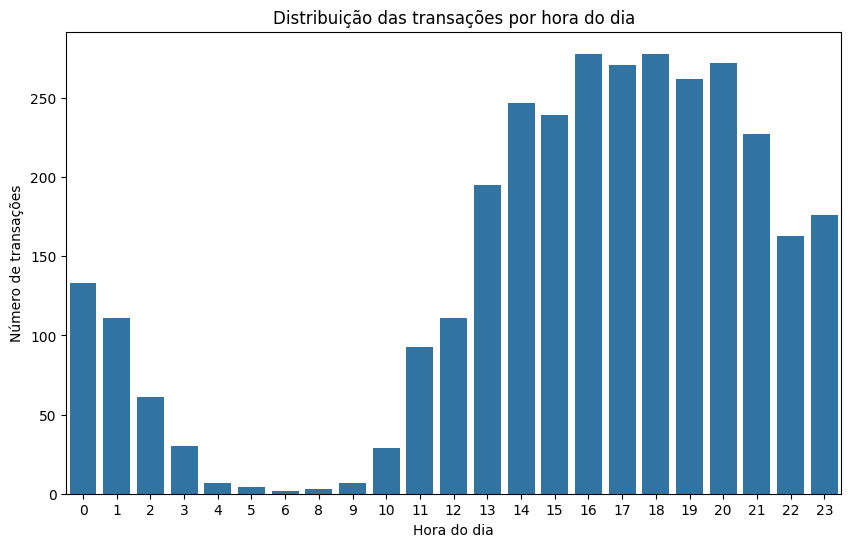

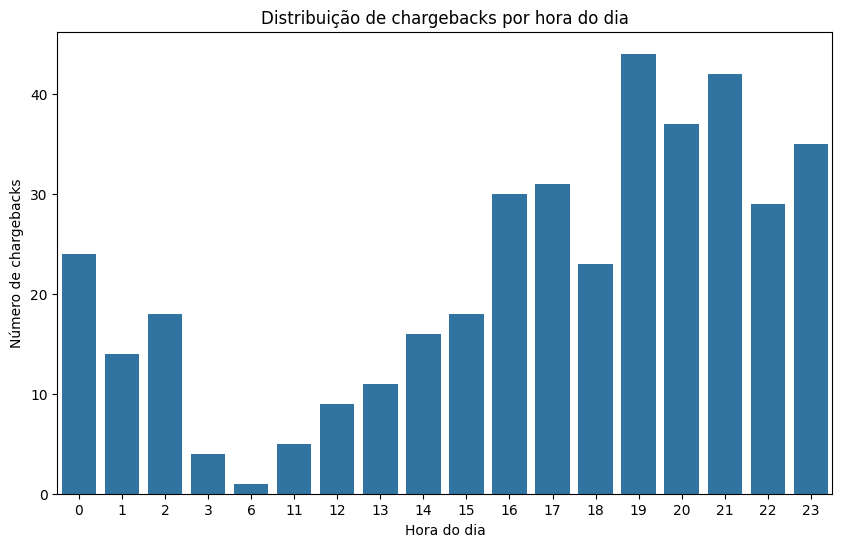

In [167]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_hour'] = df['transaction_date'].dt.hour

plt.figure(figsize=(10,6))
sns.countplot(x='transaction_hour', data=df)
plt.title('Distribuição das transações por hora do dia')
plt.xlabel('Hora do dia')
plt.ylabel('Número de transações')
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x='transaction_hour', data=df[df['has_cbk']])
plt.title('Distribuição de chargebacks por hora do dia')
plt.xlabel('Hora do dia')
plt.ylabel('Número de chargebacks')
plt.show()


### Comparativo de média de tempo entre transações (por user, devices e merchants) com chargeback e sem chargeback



*   Aqui foi analisado se a curta distancia entre transações (por user, merchants ou devices) pode ser um indicador relevante de possíveis atividades suspeitas envolvendo fraudes dentro do escopo de chargeback.
*   Foi possível observar que a hipótese é verdadeira nesse cenário, tendo em mente que em todos os casos, os registros com chargeback apresentaram intervalos muito menores de tempo entre transações, um forte indicativo de atividade coordenada ou até mesmo automatizada.



In [172]:
df_sorted = df.sort_values(by=['user_id', 'transaction_date'])
df_sorted['tempo_entre_transacoes_min'] = df_sorted.groupby('user_id')['transaction_date'].diff().dt.total_seconds() / 60

tempo_cbk = df_sorted[df_sorted['has_cbk']]['tempo_entre_transacoes_min']
tempo_nao_cbk = df_sorted[~df_sorted['has_cbk']]['tempo_entre_transacoes_min']

media_cbk = tempo_cbk.mean()
media_nao_cbk = tempo_nao_cbk.mean()

print(f"Tempo médio entre transações com chargeback por user: {media_cbk:.2f} minutos")
print(f"Tempo médio entre transações sem chargeback por user: {media_nao_cbk:.2f} minutos")

df_device = df.sort_values(by=['device_id', 'transaction_date'])
df_device['tempo_entre_transacoes_device'] = df_device.groupby('device_id')['transaction_date'].diff().dt.total_seconds() / 60

tempo_cbk_device = df_device[df_device['has_cbk']]['tempo_entre_transacoes_device']
tempo_nao_cbk_device = df_device[~df_device['has_cbk']]['tempo_entre_transacoes_device']

media_cbk_device = tempo_cbk_device.dropna().mean()
media_nao_cbk_device = tempo_nao_cbk_device.dropna().mean()

print(f"Tempo médio entre transações com chargeback por device_id: {media_cbk_device:.2f} minutos")
print(f"Tempo médio entre transações sem chargeback por device_id: {media_nao_cbk_device:.2f} minutos")

df_merchant = df.sort_values(by=['merchant_id', 'transaction_date'])
df_merchant['tempo_entre_transacoes_merchant'] = df_merchant.groupby('merchant_id')['transaction_date'].diff().dt.total_seconds() / 60

tempo_cbk_merchant = df_merchant[df_merchant['has_cbk']]['tempo_entre_transacoes_merchant']
tempo_nao_cbk_merchant = df_merchant[~df_merchant['has_cbk']]['tempo_entre_transacoes_merchant']

media_cbk_merchant = tempo_cbk_merchant.dropna().mean()
media_nao_cbk_merchant = tempo_nao_cbk_merchant.dropna().mean()

print(f"Tempo médio entre transações com chargeback por merchant_id: {media_cbk_merchant:.2f} minutos")
print(f"Tempo médio entre transações sem chargeback por merchant_id: {media_nao_cbk_merchant:.2f} minutos")


Tempo médio entre transações com chargeback por user: 960.74 minutos
Tempo médio entre transações sem chargeback por user: 3376.05 minutos
Tempo médio entre transações com chargeback por device_id: 1078.28 minutos
Tempo médio entre transações sem chargeback por device_id: 2325.72 minutos
Tempo médio entre transações com chargeback por merchant_id: 628.92 minutos
Tempo médio entre transações sem chargeback por merchant_id: 4003.14 minutos


### Análise de valores de transações por período do dia (com chargeback e sem chargeback).



*   Após a análise observei um resultado já esperado: as transações com chargeback possuem maiores médias de valores.



In [10]:
def classificar_periodo(h):
    if 0 <= h < 6:
        return 'Madrugada'
    elif 6 <= h < 12:
        return 'Manhã'
    elif 12 <= h < 18:
        return 'Tarde'
    else:
        return 'Noite'

df['periodo_dia'] = df['transaction_hour'].apply(classificar_periodo)


comparativo = df.groupby(['periodo_dia', 'has_cbk'])['transaction_amount'].agg(
    media_valor='mean',
    qtd_transacoes='count'
).reset_index()

ordem_periodos = ['Madrugada', 'Manhã', 'Tarde', 'Noite']
comparativo['periodo_dia'] = pd.Categorical(comparativo['periodo_dia'], categories=ordem_periodos, ordered=True)
comparativo = comparativo.sort_values(['periodo_dia', 'has_cbk'])

print("Comparação de valores médios e quantidade de transações por período e chargeback:")
print(comparativo)


Comparação de valores médios e quantidade de transações por período e chargeback:
  periodo_dia  has_cbk  media_valor  qtd_transacoes
0   Madrugada    False   549.362028             286
1   Madrugada     True  1263.924333              60
2       Manhã    False   692.771641             128
3       Manhã     True  1392.798333               6
6       Tarde    False   713.039894            1226
7       Tarde     True  1422.147652             115
4       Noite    False   657.455171            1168
5       Noite     True  1526.701857             210


### Top users com mais transações envolvendo devices_nulos



*   O objetivo era validar minha hipotese de que devices_nulos poderiam ser um indicativo de ação automatizada ou tentativa de mascaramento de origem da transação.
*   esse indicador isolado pode não representar muito, mas podem se tornar quando associados múltiplas vezes a um usuário, com um mesmo comerciante, em curtos intervalos de tempo e altas taxas de chargeback por transação



In [33]:

df_device_nulo = df[df['device_id'].isna()]
usuarios_com_device_nulo = df_device_nulo['user_id'].value_counts()
print("Top 10 usuários com mais transações com device_id nulo:")
print(usuarios_com_device_nulo.head(10))


Top 10 usuários com mais transações com device_id nulo:
user_id
75710    10
49106     7
18227     4
30874     4
40779     4
42677     4
76819     4
2866      3
9005      3
71433     3
Name: count, dtype: int64


In [51]:
display(df[df['user_id'] == 75710])


,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,data,tem_device,tempo_entre
2933,21323331,77130,75710,554482******7640,2019-11-08 23:05:13.814924,540.81,NaN,True,2019-11-08,False,NaN
2932,21323330,77130,75710,554482******7640,2019-11-08 23:11:18.971808,320.96,NaN,True,2019-11-08,False,6.085948
2931,21323329,77130,75710,554482******7640,2019-11-08 23:12:00.465991,254.37,NaN,True,2019-11-08,False,0.691570
2930,21323328,77130,75710,554482******7640,2019-11-08 23:14:35.977303,386.82,NaN,True,2019-11-08,False,2.591855
2929,21323327,77130,75710,554482******7640,2019-11-08 23:15:05.322183,599.13,NaN,True,2019-11-08,False,0.489081
2928,21323326,77130,75710,554482******7640,2019-11-08 23:17:08.619645,473.44,NaN,True,2019-11-08,False,2.054958
2927,21323325,77130,75710,554482******7640,2019-11-08 23:18:28.634342,254.25,NaN,True,2019-11-08,False,1.333578
2923,21323321,77130,75710,554482******7640,2019-11-09 00:17:27.310174,559.01,NaN,True,2019-11-09,False,NaN
2922,21323320,77130,75710,554482******7640,2019-11-09 00:58:24.689418,593.78,NaN,True,2019-11-09,False,40.956321
2883,21323281,77130,75710,554482******7640,2019-11-09 20:11:57.306777,1631.24,NaN,True,2019-11-09,False,1153.543623


In [52]:
display(df[df['merchant_id'] == 77130])


,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,data,tem_device,tempo_entre
2993,21323391,77130,42677,550209******1419,2019-11-07 22:09:14.359238,10.32,NaN,False,2019-11-07,False,NaN
2945,21323343,77130,42677,515601******8618,2019-11-08 20:37:19.393101,10.26,NaN,True,2019-11-08,False,NaN
2944,21323342,77130,42677,515601******8618,2019-11-08 20:41:18.782324,303.82,NaN,True,2019-11-08,False,3.989820
2943,21323341,77130,42677,515601******8618,2019-11-08 20:41:36.944243,301.58,NaN,True,2019-11-08,False,0.302699
1154,21321552,77130,42677,498442******3045,2019-11-26 19:41:25.744694,10.02,731521.0,False,2019-11-26,True,NaN
2933,21323331,77130,75710,554482******7640,2019-11-08 23:05:13.814924,540.81,NaN,True,2019-11-08,False,NaN
2932,21323330,77130,75710,554482******7640,2019-11-08 23:11:18.971808,320.96,NaN,True,2019-11-08,False,6.085948
2931,21323329,77130,75710,554482******7640,2019-11-08 23:12:00.465991,254.37,NaN,True,2019-11-08,False,0.691570
2930,21323328,77130,75710,554482******7640,2019-11-08 23:14:35.977303,386.82,NaN,True,2019-11-08,False,2.591855
2929,21323327,77130,75710,554482******7640,2019-11-08 23:15:05.322183,599.13,NaN,True,2019-11-08,False,0.489081


## Conclusão

Após uma breve análise, pude notar alguns padrões que caracterizam comportamentos suspeitos, dentre eles:



*   **Users com histórico de chargebacks** - É um forte indicativo de que o usuário está abusando do recurso, ainda mais se olharmos para a porcentagem de transações com chargeback em relação as sem.
*   **Número elevado de cartões por um mesmo usuário** - Foi possível observar que os usuários com mais cartões também eram os usuários com mais chargebacks, um forte indicativo de que esses usuários possam estar testando multiplos cartões ou até mesmo tentando evitar bloqueios automáticos associados a múltiplas transações em um mesmo cartão.
*   **Usuários com maior número de chargebacks, centralizados em poucos comerciantes** - forte indicativo de uma ação coordenada em conjunto com os comerciantes, ação muito comum em casos de lavagem de dinheiro, usado para simular transações legítimas.
*   **Compras de alto valor em curtos períodos de tempo** - Os usuários com maior número de chargebacks apresentam esse comportamento.
*   **Comerciantes com altas taxas de chargeback** - Foram localizados diversos comerciantes "alvos" com 100% das transações resultando em chargeback, comportamento que também pode indicar envolvimento do comerciante.
*   **Volume alto de transações com chargeback durante a madrugada e período noturno** - Alto volume de transações que resultaram em chargeback nesse período, podem indicar que o usuário realizou compras fora do horário comercial para evitar bloqueio manual.
*  **Tempo médio entre transações** - Observei que o intervalo entre transações é bem menor em transações que envolvem chargeback, o que pode indicar uma tentativa compras em lote no menor período possível sem que o proprietário perceba.
*  **Média de valores de transação** - A média de valores é maior em transações com chargeback, o indicador sózinho pode não demonstrar muito, mas associado ao itens anteriores é uma informação relevante para futuras análises.
*  **Transações com Devices nulos** - É um forte indicador de possíveis ações de mascaramento de origem da transação, sem origem, ficamos limitados ao análisar uma possível fraude, ainda mais se observarmos que entre os users com mais transações feitas sem device_id, é possível notar a centralização em poucos comerciantes, altos valores e intervalos de tempo curtos.

Outras informações úteis para uma análise mais completa seriam:

*  **Localização da transação** - Identificar se uma série de transações suspeitas ocorreram no mesmo local, além de identificar se a localização da origem bate com a localização do proprietário do cartão.
*  **User_agent** - Identificar possível ação de simulação de usuário em ações automatizadas.
*  **IP** - Mapear Ips suspeitos com múltiplos cartões e users.
*  **Status de compra** - em caso de lojas, seria útil ter a informação de entrega de produtos, para identificar se o pedido de chargeback foi feito antes ou após a chegada do produto.
